In [39]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 1000)
idx = pd.IndexSlice

from pprint import pprint

import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot
jtplot.style(context='paper', theme='grade3', grid=False, ticks=True)
DFT_FIG_WIDTH_WIDE = 11
DFT_FIG_WIDTH = 5.3
%matplotlib inline
%config InlineBackend.figure_format ='retina'
COLORS = plt.get_cmap('tab10')
# Choose in ['Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2', 'Set1', 'Set2', 'Set3', 
# 'tab10', 'tab20', 'tab20b', 'tab20c']
# See https://matplotlib.org/3.5.0/_images/sphx_glr_colormaps_006_2_0x.png

import pickle

def write_pickle(path, obj):
    with open(path, 'wb') as f:
        pickle.dump(obj, f)

def read_pickle(path):
    with open(path, 'rb') as f:
        obj = pickle.load(f)
    return obj

from simulation import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Ordinary MC

In [15]:
from statsmodels.stats.proportion import proportion_confint

def read_data_omc(alpha=.05):
    dirc = 'data/surface_code_bitflip_lsd0_omc'
    fnames = os.listdir(dirc)
    dfs = []
    for fname in fnames:
        if fname.endswith('.pkl'):
            path = os.path.join(dirc, fname)
            data = read_pickle(path)
            d = data['d']
            p = data['p']
            df = data['df']
            
            num_fails = df['num_fails_cf'].values.cumsum()
            num_accepted = df['num_samples_cf'].values.cumsum()
            c = 1 - df.index
            num_samples = num_accepted[-1]
            
            mask = num_accepted > 0
            num_fails = num_fails[mask]
            num_accepted = num_accepted[mask]
            c = c[mask]

            pfail_low, pfail_upp = proportion_confint(num_fails,
                                                    num_accepted,
                                                    alpha=alpha,
                                                    method='wilson')
            pfail = (pfail_low + pfail_upp) / 2
            delta_pfail = pfail_upp - pfail
            
            pabort_low, pabort_upp \
                = proportion_confint(num_samples - num_accepted,
                                     num_samples,
                                     alpha=alpha,
                                     method='wilson')
            pabort = (pabort_low + pabort_upp) / 2
            delta_pabort = pabort_upp - pabort

            df_ps = pd.DataFrame({'c': c,
                                  'pfail': pfail,
                                  'delta_pfail': delta_pfail,
                                  'pabort': pabort,
                                  'delta_pabort': delta_pabort})
            df_ps['d'] = d
            df_ps['p'] = p
            df_ps['total_shots'] = num_samples
            df_ps = df_ps.set_index(['c', 'd', 'p']).sort_index()
            dfs.append(df_ps)
    
    df = pd.concat(dfs).sort_index()
    
    df_mc_full = pd.read_pickle('data/surface_code_bitflip_lsd0_omc_full/surface_code_bitflip_lsd0_ps')
    df_mc_full = df_mc_full.loc[idx['cluster_frac', :, :, :], :].droplevel('strategy')
    df_mc_full.rename(columns={'fail': 'pfail', 'delta_fail': 'delta_pfail', 'abort': 'pabort', 'delta_abort': 'delta_pabort'}, inplace=True)
    df_mc_full = df_mc_full[~df_mc_full.index.isin(df.index)]
    df = pd.concat([df, df_mc_full]).sort_index()
    
    return df

In [32]:
df = read_data_omc().loc[idx[0.92, :, :], :]
df['acc_rate'] = 1 - df['pabort']
df

pfail   delta_pfail    pabort  delta_pabort  \
c    d  p                                                          
0.92 11 0.01  1.167649e-06  8.943169e-07  0.000250  1.391850e-05   
        0.02  2.151967e-05  4.162247e-06  0.005172  6.289993e-05   
        0.03  1.395738e-04  1.056986e-05  0.030453  1.506500e-04   
        0.04  4.544859e-04  1.976372e-05  0.098341  2.610836e-04   
        0.05  9.851779e-04  3.114526e-05  0.216199  3.609000e-04   
        0.06  1.789466e-03  4.678893e-05  0.369090  4.230000e-04   
        0.07  2.847641e-03  6.827985e-05  0.529722  4.375500e-04   
        0.08  4.233085e-03  9.979507e-05  0.674334  4.108000e-04   
        0.09  5.840803e-03  1.458916e-04  0.789413  3.574956e-04   
        0.10  8.310092e-03  2.224178e-04  0.871239  2.936000e-04   
        0.11  1.131754e-02  3.398024e-04  0.925397  2.303777e-04   
        0.12  1.592905e-02  5.407974e-04  0.958671  1.745746e-04   
        0.13  2.120833e-02  8.547688e-04  0.977970  1.287312e-04   
        0.14  2.840723e-02  1.370609e-03  0.988561  9.325008e-05   
        0.15  3.719663e-02  4.886997e-04  0.994240  1.483237e-05   
        0.16  4.914454e-02  7.947262e-04  0.997158  1.043375e-05   
        0.17  6.423081e-02  1.291032e-03  0.998615  7.289382e-06   
        0.18  8.364510e-02  1.194343e-03  0.999335  2.868883e-06   
        0.19  1.088198e-01  1.012321e-03  0.999683  1.030627e-06   
        0.20  1.374289e-01  8.588947e-04  0.999850  3.747777e-07   
        0.21  1.749052e-01  8.812995e-03  0.999929  1.655149e-06   
        0.22  2.189096e-01  1.343763e-02  0.999964  1.181328e-06   
        0.23  2.673229e-01  2.003239e-02  0.999981  8.477666e-07   
        0.24  3.820370e-01  1.413855e-01  0.999991  2.617553e-06   
        0.25  3.049532e-01  1.950468e-01  0.999996  1.811966e-06   
        0.26  3.800397e-01  2.136770e-01  0.999996  1.729980e-06   
        0.27  5.000000e-01  4.023885e-01  0.999999  8.940940e-07   
        0.28  5.591990e-01  4.238486e-01  0.999999  7.990014e-07   
        0.29  3.881966e-01  3.881966e-01  0.999999  6.939597e-07   
        0.30  3.881966e-01  3.881966e-01  0.999999  6.939597e-07   
     13 0.01  3.898176e-07  3.898176e-07  0.000116  9.524350e-06   
        0.02  4.938560e-06  1.947845e-06  0.002207  4.122938e-05   
        0.03  5.530582e-05  6.643925e-06  0.016266  1.109805e-04   
        0.04  2.328988e-04  1.394827e-05  0.065677  2.171500e-04   
        0.05  6.082052e-04  2.381990e-05  0.172684  3.313500e-04   
        0.06  1.201290e-03  3.720763e-05  0.332117  4.128500e-04   
        0.07  2.077625e-03  5.734772e-05  0.513299  4.381500e-04   
        0.08  3.241662e-03  8.818912e-05  0.680234  4.088500e-04   
        0.09  4.850258e-03  1.396688e-04  0.808713  3.448000e-04   
        0.10  6.800378e-03  2.242960e-04  0.896006  2.676000e-04   
        0.11  9.794605e-03  3.765117e-04  0.947115  1.962997e-04   
        0.12  1.373048e-02  6.485498e-04  0.975097  1.366500e-04   
        0.13  1.944617e-02  1.154493e-03  0.988852  9.211338e-05   
        0.14  2.705556e-02  2.088356e-03  0.995331  5.982030e-05   
        0.15  3.439986e-02  7.155124e-04  0.998062  7.600374e-06   
        0.16  4.726915e-02  5.973317e-04  0.999233  2.158941e-06   
        0.17  6.308825e-02  2.872187e-04  0.999705  3.485115e-07   
        0.18  8.967466e-02  5.295968e-03  0.999888  2.071332e-06   
        0.19  1.152174e-01  9.833955e-03  0.999960  1.245895e-06   
        0.20  1.331763e-01  1.640225e-02  0.999985  7.402622e-07   
        0.21  1.722663e-01  3.050150e-02  0.999994  4.732235e-07   
        0.22  2.670570e-01  5.507093e-02  0.999998  3.061309e-07   
        0.23  3.246525e-01  1.023440e-01  0.999999  1.719418e-07   
        0.24  2.500000e-01  2.500000e-01  0.999999  9.960660e-07   
        0.25  5.000000e-01  4.746794e-01  0.999999  6.939597e-07   
     15 0.01  3.898174e-07  3.898174e-07  0.000037  5.352081e-06   
        0.02  2.584635e-06  1.432033e-06  0.001229  3.075029e-05   
        0

(0.18, 0.23)

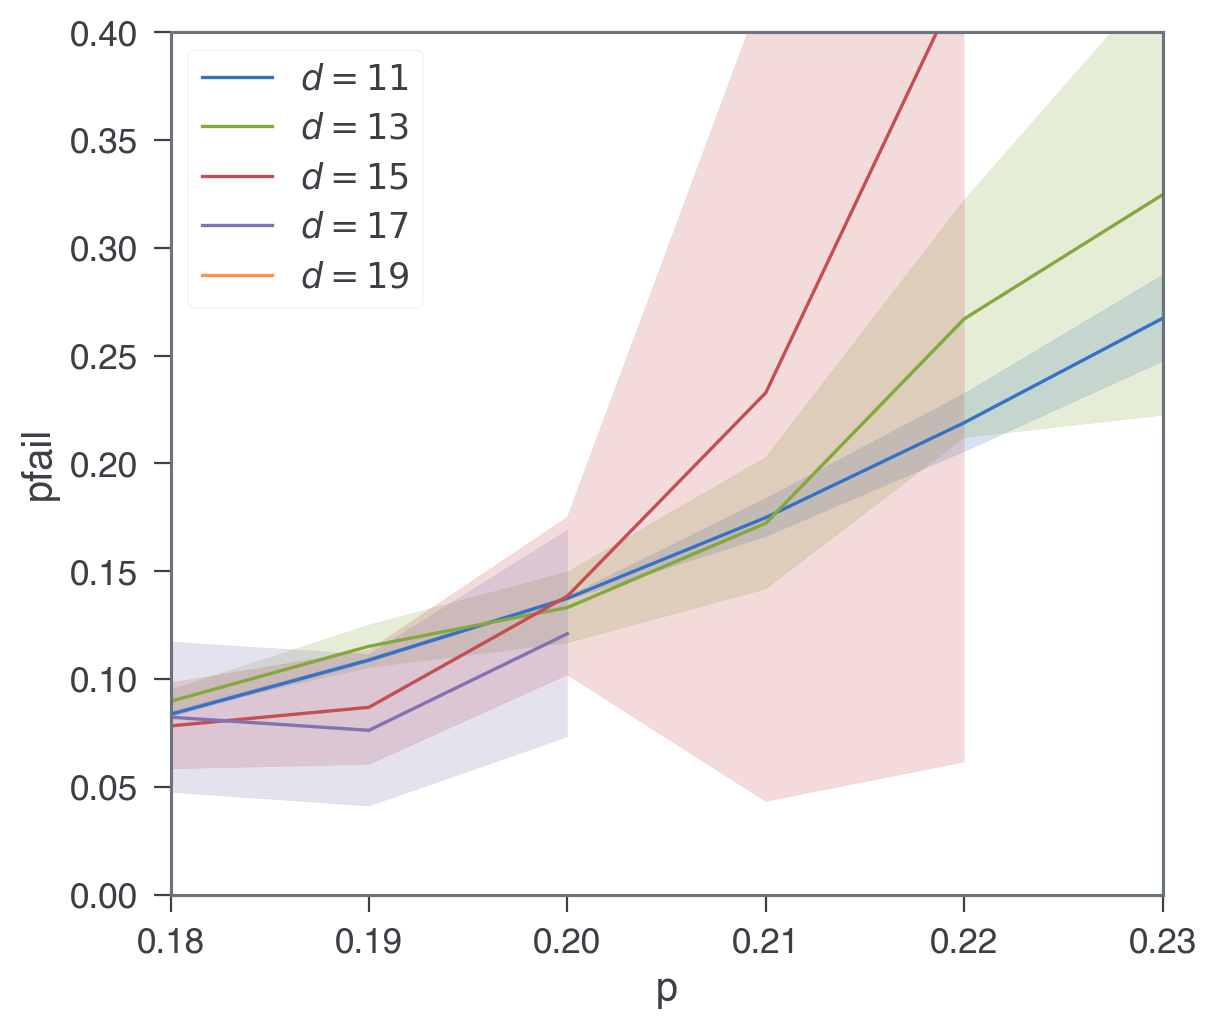

In [35]:
ds = df.index.get_level_values('d').unique()
for d in ds:
    plot_error_band(df.loc[idx[:, d, :], :].reset_index(), 
                    x='p', y='pfail', delta_y='delta_pfail', label=r'$d={}$'.format(d))
plt.ylim([0, 0.4])
plt.xlim([0.18, 0.23])
# plt.yscale('log')
# plt.xscale('log')

In [36]:
df

pfail   delta_pfail    pabort  delta_pabort  \
c    d  p                                                          
0.92 11 0.01  1.167649e-06  8.943169e-07  0.000250  1.391850e-05   
        0.02  2.151967e-05  4.162247e-06  0.005172  6.289993e-05   
        0.03  1.395738e-04  1.056986e-05  0.030453  1.506500e-04   
        0.04  4.544859e-04  1.976372e-05  0.098341  2.610836e-04   
        0.05  9.851779e-04  3.114526e-05  0.216199  3.609000e-04   
        0.06  1.789466e-03  4.678893e-05  0.369090  4.230000e-04   
        0.07  2.847641e-03  6.827985e-05  0.529722  4.375500e-04   
        0.08  4.233085e-03  9.979507e-05  0.674334  4.108000e-04   
        0.09  5.840803e-03  1.458916e-04  0.789413  3.574956e-04   
        0.10  8.310092e-03  2.224178e-04  0.871239  2.936000e-04   
        0.11  1.131754e-02  3.398024e-04  0.925397  2.303777e-04   
        0.12  1.592905e-02  5.407974e-04  0.958671  1.745746e-04   
        0.13  2.120833e-02  8.547688e-04  0.977970  1.287312e-04   
        0.14  2.840723e-02  1.370609e-03  0.988561  9.325008e-05   
        0.15  3.719663e-02  4.886997e-04  0.994240  1.483237e-05   
        0.16  4.914454e-02  7.947262e-04  0.997158  1.043375e-05   
        0.17  6.423081e-02  1.291032e-03  0.998615  7.289382e-06   
        0.18  8.364510e-02  1.194343e-03  0.999335  2.868883e-06   
        0.19  1.088198e-01  1.012321e-03  0.999683  1.030627e-06   
        0.20  1.374289e-01  8.588947e-04  0.999850  3.747777e-07   
        0.21  1.749052e-01  8.812995e-03  0.999929  1.655149e-06   
        0.22  2.189096e-01  1.343763e-02  0.999964  1.181328e-06   
        0.23  2.673229e-01  2.003239e-02  0.999981  8.477666e-07   
        0.24  3.820370e-01  1.413855e-01  0.999991  2.617553e-06   
        0.25  3.049532e-01  1.950468e-01  0.999996  1.811966e-06   
        0.26  3.800397e-01  2.136770e-01  0.999996  1.729980e-06   
        0.27  5.000000e-01  4.023885e-01  0.999999  8.940940e-07   
        0.28  5.591990e-01  4.238486e-01  0.999999  7.990014e-07   
        0.29  3.881966e-01  3.881966e-01  0.999999  6.939597e-07   
        0.30  3.881966e-01  3.881966e-01  0.999999  6.939597e-07   
     13 0.01  3.898176e-07  3.898176e-07  0.000116  9.524350e-06   
        0.02  4.938560e-06  1.947845e-06  0.002207  4.122938e-05   
        0.03  5.530582e-05  6.643925e-06  0.016266  1.109805e-04   
        0.04  2.328988e-04  1.394827e-05  0.065677  2.171500e-04   
        0.05  6.082052e-04  2.381990e-05  0.172684  3.313500e-04   
        0.06  1.201290e-03  3.720763e-05  0.332117  4.128500e-04   
        0.07  2.077625e-03  5.734772e-05  0.513299  4.381500e-04   
        0.08  3.241662e-03  8.818912e-05  0.680234  4.088500e-04   
        0.09  4.850258e-03  1.396688e-04  0.808713  3.448000e-04   
        0.10  6.800378e-03  2.242960e-04  0.896006  2.676000e-04   
        0.11  9.794605e-03  3.765117e-04  0.947115  1.962997e-04   
        0.12  1.373048e-02  6.485498e-04  0.975097  1.366500e-04   
        0.13  1.944617e-02  1.154493e-03  0.988852  9.211338e-05   
        0.14  2.705556e-02  2.088356e-03  0.995331  5.982030e-05   
        0.15  3.439986e-02  7.155124e-04  0.998062  7.600374e-06   
        0.16  4.726915e-02  5.973317e-04  0.999233  2.158941e-06   
        0.17  6.308825e-02  2.872187e-04  0.999705  3.485115e-07   
        0.18  8.967466e-02  5.295968e-03  0.999888  2.071332e-06   
        0.19  1.152174e-01  9.833955e-03  0.999960  1.245895e-06   
        0.20  1.331763e-01  1.640225e-02  0.999985  7.402622e-07   
        0.21  1.722663e-01  3.050150e-02  0.999994  4.732235e-07   
        0.22  2.670570e-01  5.507093e-02  0.999998  3.061309e-07   
        0.23  3.246525e-01  1.023440e-01  0.999999  1.719418e-07   
        0.24  2.500000e-01  2.500000e-01  0.999999  9.960660e-07   
        0.25  5.000000e-01  4.746794e-01  0.999999  6.939597e-07   
     15 0.01  3.898174e-07  3.898174e-07  0.000037  5.352081e-06   
        0.02  2.584635e-06  1.432033e-06  0.001229  3.075029e-05   
        0

In [37]:
# Required shots for achieving a target tolerance

target_tol = 0.005
pfails = df['pfail']
paborts = df['pabort']
total_shots = df['total_shots']
required_shots = pfails * (1 - pfails) / (target_tol / 1.96)**2 / (1 - paborts)
# estimated_time = np.maximum((required_shots - total_shots), 0)
df['required_shots'] = required_shots

In [38]:
# Apply the ceiling operation and scale to 1e7
df_partial = df[(df['delta_pfail'] > target_tol) & (df['pabort'] < 1 - 1e-7)]
df_partial = df_partial.loc[idx[:, :, 0.18:0.23]]

# Print the result as a dictionary
pprint(dict(zip(df_partial.index, (df_partial['required_shots']).astype('int64'))))

{(0.92, 11, 0.21): 310893244,
 (0.92, 11, 0.22): 723040892,
 (0.92, 11, 0.23): 1607805377,
 (0.92, 13, 0.18): 112292186,
 (0.92, 13, 0.19): 387559927,
 (0.92, 13, 0.2): 1158739814,
 (0.92, 13, 0.21): 3752400480,
 (0.92, 13, 0.22): 12280632406,
 (0.92, 13, 0.23): 43237959584,
 (0.92, 15, 0.18): 1613995195,
 (0.92, 15, 0.19): 6228295763,
 (0.92, 15, 0.2): 37092404443,
 (0.92, 15, 0.21): 183940169741,
 (0.92, 17, 0.18): 24990683134}


# MCMC

In [71]:
# dirc_backup = 'backup-241203-extradata'
# dirc = 'data/surface_code_bitflip_lsd0_mcmc'
# data = read_pickle(os.path.join(dirc, dirc_backup, f'c{0.9}_d{19}_p{0.19}_{0}.pkl'))

In [67]:
# # Restore before applying the adaptive method
# dirc_backup = 'backup-241203-extradata'
# dirc = 'data/surface_code_bitflip_lsd0_mcmc'
# indices = [(0.9, 19, 0.19), (0.9, 19, 0.2)]
# for fname in os.listdir(os.path.join(dirc, dirc_backup)):
#     path_backup = os.path.join(dirc, dirc_backup, fname)
#     path = os.path.join(dirc, fname)
#     if os.path.exists(path):
#         continue
    
#     data = read_pickle(path_backup)
#     c, d, p, chain = data['c'], data['d'], data['p'], data['chain_id']

#     print(c, d, p, chain)
    
#     circuit = build_circuit_surface_code(d, 1, p_bitflip=p)
#     mcmc = MCMC(c=c, circuit=circuit, _force_no_e0=True)
#     mcmc._fails = data['fails'].tolist()
#     mcmc.last_error = data['last_error']
#     mcmc.shots_acc = mcmc.shots_dec = 0

#     mcmc.save(path)

0.9 17 0.19 2
0.9 17 0.19 3
0.9 17 0.19 1
0.9 17 0.19 0
0.9 19 0.18 1
0.9 19 0.18 0
0.9 19 0.18 2
0.9 19 0.18 3
0.9 17 0.2 3
0.9 17 0.2 2
0.9 17 0.2 0
0.9 17 0.2 1


In [94]:
mcmc = MCMC.load(
    os.path.join(dirc, 'backup-241206-adaptive_nflip_0.234',
                 'mcmc_c0.9_d19_p0.19_2.pkl'))

In [3]:
def load_mcmc(c, d, p, chain):
    dirc = f'data/surface_code_bitflip_lsd0_mcmc'
    path = os.path.join(dirc, f'c{c}_d{d}_p{p}_{chain}.pkl')
    return MCMC.load(path)

In [ ]:
import os
# dirc = f'data/surface_code_bitflip_lsd0_mcmc'
indices = [(0.9, 19, 0.19), (0.9, 19, 0.2)]
Nc = 4
fails_dict = {}
for c, d, p in indices:
    for chain in range(Nc):
        print(c, d, p, chain)
        mcmc = load_mcmc(c, d, p, chain)
        try:
            fails_dict[(c, d, p)].append(mcmc._fails)
        except KeyError:
            fails_dict[(c, d, p)] = [mcmc._fails]

        del mcmc
        
for index, fails_sng in fails_dict.items():
    try:
        fails_sng = np.array(fails_sng)
    except ValueError:
        min_length = min(len(arr) for arr in fails_sng)
        fails_sng = np.array([arr[:min_length] for arr in fails_sng])
    fails_dict[index] = fails_sng
    print(index, fails_sng.shape[1])
del fails_sng

0.9 19 0.19 0
0.9 19 0.19 1
0.9 19 0.19 2
0.9 19 0.19 3


In [55]:
# import arviz as az

# az.Numba.disable_numba()

# idatas = {}
# for (c, d, p), fails_sng in fails.items():
#     idata = az.convert_to_inference_data(fails_sng)
#     idatas[(c, d, p)] = idata

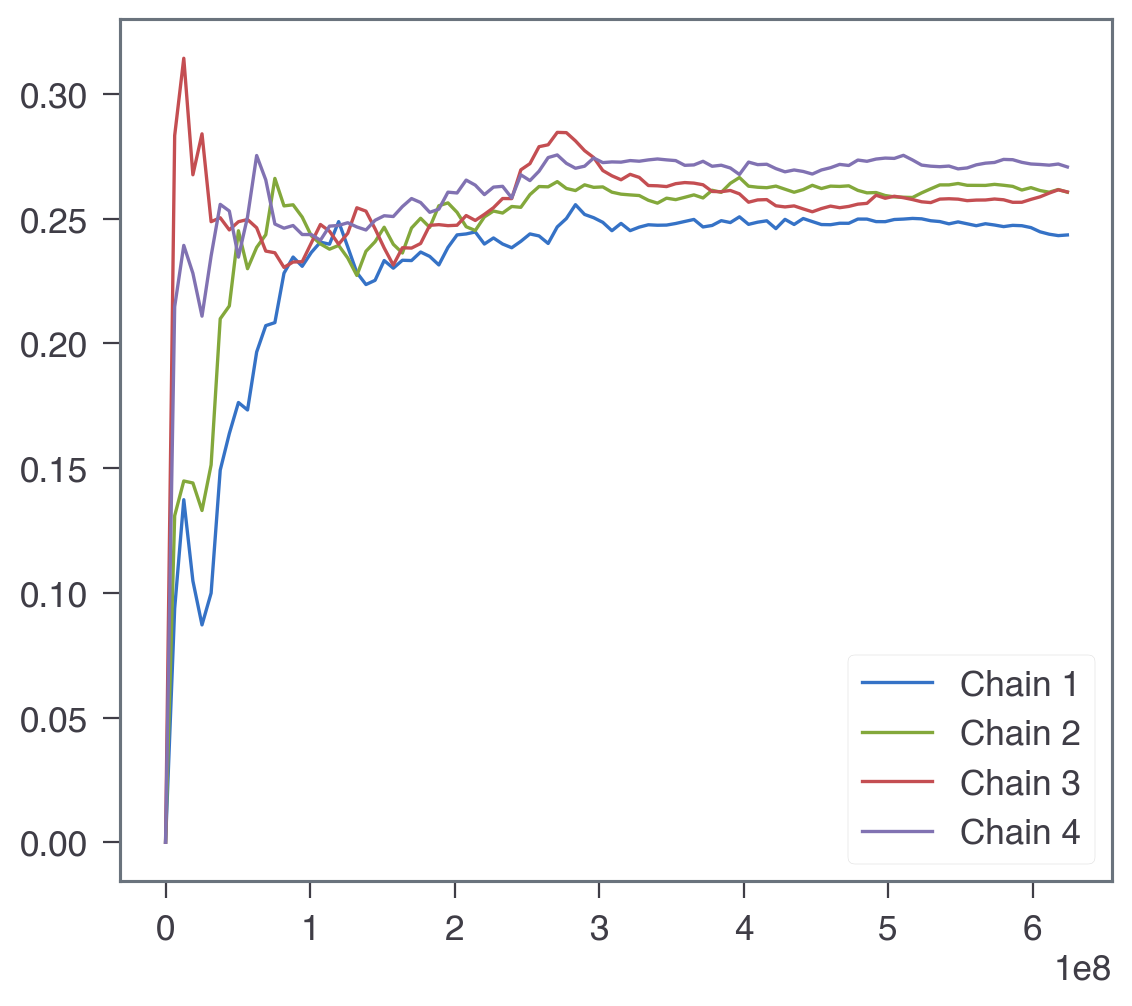

In [9]:
# Plot the cumulative averages for each chain
fails_now = fails[(0.9, 19, 0.20)]  # Shape: (chains, draws)
pfails = np.cumsum(fails_now, axis=1) / (np.arange(1, fails_now.shape[1] + 1))
x = np.round(np.linspace(0, fails_now.shape[1] - 1, 100)).astype('int64')
for i_chain in range(4):
    y = pfails[i_chain, x]
    plt.plot(x, y, label=f'Chain {i_chain+1}')

# Add labels and legend
plt.legend()
plt.show()

In [ ]:
from tqdm import tqdm

# columns = ['c', 'd', 'p', 'iteration', 'pfail', 'delta_pfail', 'mcse', 'rhat', 'rhat_cluster', 'rhat_errors','rhat_defects']
columns = ['c', 'd', 'p', 'iteration', 'pfail', 'delta_pfail', 'mcse', 'ess']
stats = pd.DataFrame(columns=columns,
                     dtype='float64')
stats = stats.set_index(['c', 'd', 'p'])

for index, fails in fails_dict.items():
    print(index)
    ess = az.ess(fails)
    shots = fails.shape[1]
    pfail = fails.sum() / fails.size
#     mcse = az.mcse(idata)['x'].values
#     rhat = az.rhat(idata)['x'].values
    mcse = np.sqrt(pfail * (1 - pfail) / ess)
#     rhat, rhat_cluster, rhat_errors, rhat_defects = [rhats[var_name].values for var_name in variables]
    stats.loc[index, :] = shots, pfail, None, mcse, ess
stats['delta_pfail'] = stats['mcse'] * 1.96
stats.sort_index(inplace=True)
stats

(0.9, 19, 0.19)


## misc.

In [58]:
np.mean([load_mcmc(0.9, 19, 0.19, i).sampling_rate for i in range(4)])

514.6776772981024

In [60]:
np.mean([load_mcmc(0.9, 19, 0.2, i).sampling_rate for i in range(4)])

480.66573986441085

In [61]:
(514.6776772981024 + 480.66573986441085) / 2

497.6717085812566

In [64]:
# Ordinary MC time cost (samples per sec, core)
target_n_samples = {
    (0.9, 13, 0.19): 44422553,
    (0.9, 13, 0.2): 107252700,
    (0.9, 15, 0.18): 67183930,
    (0.9, 15, 0.19): 216021303,
    (0.9, 15, 0.2): 681716770,
    (0.9, 17, 0.17): 118242802,
    (0.9, 17, 0.18): 490669899,
    (0.9, 19, 0.16): 117270470,
    (0.9, 19, 0.17): 769415034
}
time_cost_mc = (sum(target_n_samples.values()) - 30000000*len(target_n_samples))/(38.5*3600*16)
time_cost_mc

1056.1848218795094

In [67]:
# MCMC time cost (ESS per sec, core)
time_cost_mcmc = stats['ess'].sum() / (stats['iteration'].mean() / 497.6717085812566 * 8)
time_cost_mcmc

0.0013288399289613114

In [68]:
# Thres acceptance rate
time_cost_mcmc / time_cost_mc

1.2581509423668906e-06

In [200]:
# Metropolis strategy comparison

c, d, p = 0.9, 19, 0.19
circuit = build_circuit_surface_code(d, 1, p_bitflip=p)
dem = circuit.detector_error_model()

def task(shots, e0, flip_single_qubit, avg_num_qubits_flipped):
    fails, last_error, _ = mcmc_sample(
        shots,
        c=c,
        dem=dem,
        e0=e0,
        return_acc_rates=False,
        flip_single_qubit=flip_single_qubit,
        avg_num_qubits_flipped=avg_num_qubits_flipped,
        include_e0=False)
    return fails, last_error

In [167]:
strategies = [(True, 1), (False, 1), (False, 2), (False, 3)]
strategies = [item for item in strategies for _ in range(4)]
e0s = [read_pickle(os.path.join(dirc, f'c{c}_d{d}_p{p}_{chain}.pkl'))['last_error'] 
       for chain in range(4)] * 4

In [168]:
from joblib import Parallel, delayed

shots = round(1e5)
i = 0
fails_all = [np.array([], dtype='bool') for _ in range(len(e0s))]
for _ in range(1000):
    print(i*shots)
    outputs = Parallel(n_jobs=16)(delayed(task)(shots, e0, *strat) 
                                  for e0, strat in zip(e0s, strategies))
    fails_all_now = [o[0] for o in outputs]
    fails_all = [np.concatenate([fails, fails_now]) 
                 for fails, fails_now in zip(fails_all, fails_all_now)]
    e0s = [o[1] for o in outputs]
    i += 1

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000
3800000
3900000
4000000
4100000
4200000
4300000
4400000
4500000
4600000
4700000
4800000
4900000
5000000
5100000
5200000
5300000
5400000
5500000
5600000
5700000
5800000
5900000
6000000
6100000
6200000
6300000
6400000
6500000
6600000
6700000
6800000
6900000
7000000
7100000
7200000
7300000
7400000
7500000
7600000
7700000
7800000
7900000
8000000
8100000
8200000
8300000
8400000
8500000
8600000
8700000
8800000
8900000
9000000
9100000
9200000
9300000
9400000
9500000
9600000
9700000
9800000
9900000
10000000
10100000
10200000
10300000
10400000
10500000
10600000
10700000
10800000
10900000
11000000
11100000
11200000
11300000
11400000
11500000
11600000
11700000
11800000
11900000
12000000
12100000
12200000
12300000

KeyboardInterrupt: 

In [174]:
fails_all = np.stack(fails_all, axis=0).reshape(4, 4, -1)  # (strategy, chain, samples)

In [175]:
fails_all.shape

(4, 4, 27000000)

In [176]:
# num_fails_prev = []
# num_shots_prev = []
# for chain in range(4):
#     data = read_pickle(os.path.join(dirc, f'c{c}_d{d}_p{p}_{chain}.pkl'))
#     num_fails_prev.append(data['fails'].sum())
#     num_shots_prev.append(data['fails'].shape[0])
# num_fails_prev = np.array(num_fails_prev).reshape(1, -1, 1)
# num_shots_prev = np.array(num_shots_prev).reshape(1, -1, 1)
    
pfails = fails_all.cumsum(axis=2)
pfails = pfails / (np.arange(1, fails_all.shape[2] + 1).reshape(1, 1, -1))

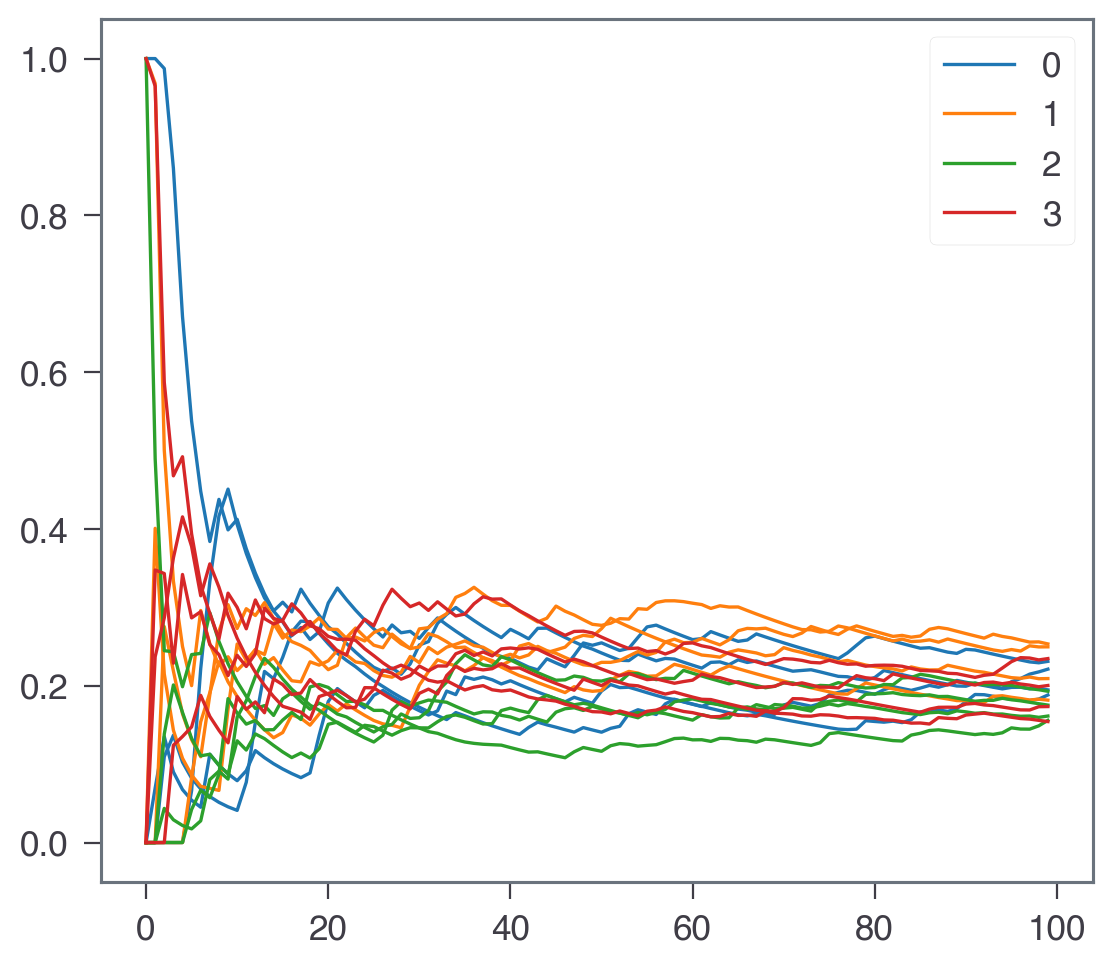

In [195]:
for strategy in [0, 1, 2, 3]:
    color=COLORS(strategy)
    for chain in range(4):
        label = strategy if chain == 0 else None
        plt.plot(pfails[strategy, chain, ::round(pfails.shape[2]/100)], color=color, label=label)
plt.legend()

In [184]:
import arviz as az

az.Numba.enable_numba()

for i in range(4):
    idata = az.convert_to_inference_data(fails_all[i, :, :])
    ess = az.ess(idata)
    print(ess)

<xarray.Dataset> Size: 8B
Dimensions:  ()
Data variables:
    x        float64 8B 363.3
<xarray.Dataset> Size: 8B
Dimensions:  ()
Data variables:
    x        float64 8B 569.0
<xarray.Dataset> Size: 8B
Dimensions:  ()
Data variables:
    x        float64 8B 755.1
<xarray.Dataset> Size: 8B
Dimensions:  ()
Data variables:
    x        float64 8B 778.8


In [190]:
ess = np.array([363.3, 569.0, 755.1, 778.8])

In [186]:
import time
taken_times = []
for e0, strat in zip(e0s, strategies):
    t0 = time.time()
    task(10000, e0, *strat)
    taken_time = time.time() - t0
    print(taken_time)
    taken_times.append(taken_time/10000)

15.524724006652832
15.093441009521484
14.988033056259155
14.867686986923218
13.092067003250122
13.720426082611084
13.542536973953247
14.267701148986816
9.85733699798584
10.143641948699951
12.296375036239624
11.422415018081665
7.4089579582214355
7.2947399616241455
8.130332946777344
9.42455506324768


In [222]:
import time

taken_times = []
n_flips = np.arange(1, 21)
shots = 50_000
e0 = e0s[0]

results = []
for n_flip in n_flips:
    t0 = time.time()
    _, _, outputs = mcmc_sample(
        shots,
        c=c,
        dem=dem,
        e0=e0,
        return_acc_rates=True,
        flip_single_qubit=False,
        avg_num_qubits_flipped=n_flip,
        p_flip=None,
        include_e0=False)
    taken_time = time.time() - t0
    result = shots/taken_time, outputs['acc_rate'], outputs['decoded_rate'], outputs['acc_rate'] / outputs['decoded_rate']
    print(n_flip, result)
    results.append(result)

1 (720.890669464056, 0.13562, 0.29096, 0.4661121803684355)
2 (891.3853387966208, 0.0935, 0.23196, 0.40308673909294707)
3 (1083.1847101063668, 0.05642, 0.18928, 0.2980769230769231)
4 (1667.9187610805266, 0.03786, 0.12088, 0.3132031767041694)
5 (2485.8362940239836, 0.02456, 0.07862, 0.3123887051640804)
6 (3346.9944221441147, 0.01442, 0.05638, 0.2557644554806669)
7 (3742.506049901639, 0.00944, 0.04958, 0.19039935457845908)
8 (5619.63388313772, 0.00388, 0.03058, 0.12688031393067364)
9 (9022.168101741341, 0.0034, 0.01636, 0.20782396088019559)
10 (11197.926873065935, 0.00142, 0.01176, 0.1207482993197279)
11 (15714.034590549814, 0.00092, 0.00626, 0.14696485623003194)
12 (14470.86364438674, 0.00068, 0.00768, 0.08854166666666667)
13 (18705.348342908313, 0.00028, 0.00414, 0.06763285024154589)
14 (21823.766450800133, 0.00016, 0.00254, 0.06299212598425197)
15 (21722.290136143416, 8e-05, 0.00248, 0.03225806451612904)
16 (24289.25772219643, 6e-05, 0.0015, 0.04)
17 (27564.35027241646, 0.0, 0.00068, 0

0.00038838743543013847

In [187]:
taken_times = np.array(taken_times)

In [191]:
ess / (taken_times * fails_all.shape[2]).reshape(4, 4).mean(axis=1)

array([0.00890008, 0.01543246, 0.0255872 , 0.03576653])

# Combined

In [86]:
df = read_data_omc()
df['mcmc'] = False

for index in stats.index:
    df.loc[index, ['pfail', 'delta_pfail', 'mcmc']] = (*stats.loc[index, ['pfail', 'delta_pfail']], True)

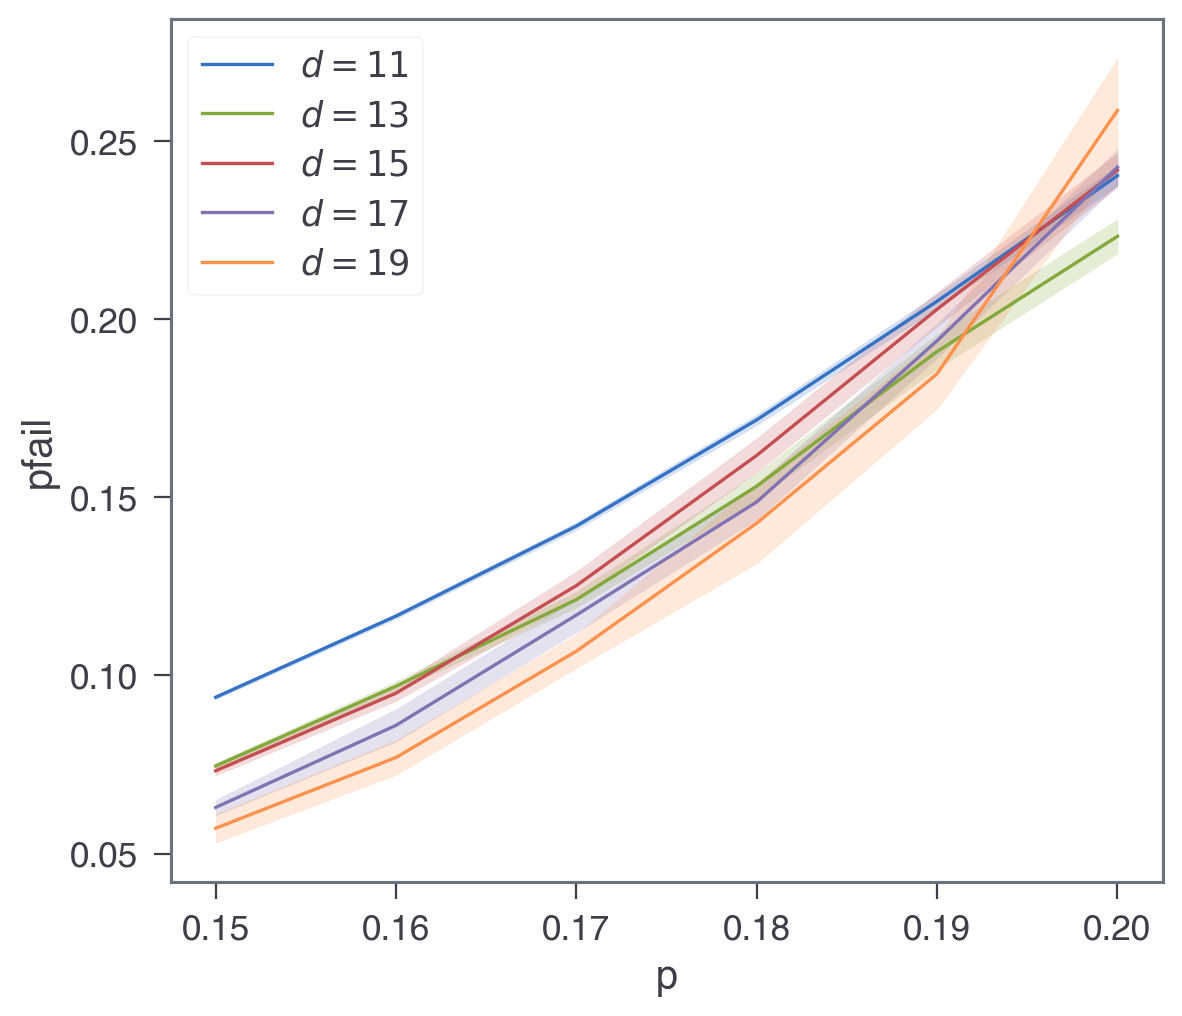

In [88]:
ds = list(df.index.get_level_values('d').unique())
ds.sort()
for d in ds:
    df_plot = df.loc[idx[0.9, d, 0.15:0.2], :].reset_index()
#     df_plot = df_plot[df_plot['delta_pfail'] < df_plot['pfail'] * 0.1]
    plot_error_band(df_plot, 
                    x='p', y='pfail', delta_y='delta_pfail', label=r'$d={}$'.format(d))
# plt.ylim([0, 0.5])
# plt.yscale('log')
# plt.xticks(np.arange(0.1, 0.205, 0.01))
plt.show()